In [2]:
import os
from pathlib import Path
import spectral
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.morphology import remove_small_objects, binary_closing

In [8]:
# Example input files
bil_file = "Good Blueberry 1-42.bil"  # Replace with your .bil file path
output_dir = "blueberry_crops"

# Load the hyperspectral image using spectral library
hsi_image = spectral.open_image(f"{bil_file}.hdr").load()

# Dimensions of the grid (6x7 for 42 blueberries)
rows, cols = 7, 6

# Get the image dimensions
image_height, image_width, bands = hsi_image.shape

# Calculate crop dimensions
crop_height = image_height // rows
crop_width = image_width // cols

# Create output directory if it doesn't exist
Path(output_dir).mkdir(exist_ok=True)

# Crop and save each blueberry
for row in range(rows):
    for col in range(cols):
        # Calculate the crop bounds
        top = row * crop_height
        bottom = (row + 1) * crop_height
        left = col * crop_width
        right = (col + 1) * crop_width
        
        # Extract the crop
        blueberry = hsi_image[top:bottom, left:right, :]

        # Save the cropped image
        filename = os.path.join(output_dir, f"blueberry_{row}_{col}.npy")
        np.save(filename, blueberry)

        # Optional: Print the dimensions of each crop for verification
        print(f"Saved: {filename} | Crop dimensions: {blueberry.shape}")

print(f"All blueberries cropped and saved in '{output_dir}'")

Saved: blueberry_crops\blueberry_0_0.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_0_1.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_0_2.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_0_3.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_0_4.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_0_5.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_1_0.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_1_1.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_1_2.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_1_3.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_1_4.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_1_5.npy | Crop dimensions: (219, 211, 462)
Saved: blueberry_crops\blueberry_2_0.npy | Crop dimensions: (219, 211, 462)
Saved: blueb

Crop dimensions: (213, 213, 462)
Data type: float32


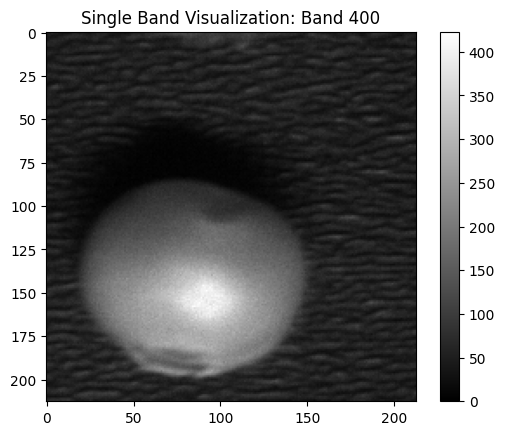

In [3]:
# File path to the .npy file
npy_file = "blueberry_crops_2/blueberry_4_3.npy"  # Replace with your file path

# Load the .npy file
crop = np.load(npy_file)

# Display dimensions and data type of the crop
print(f"Crop dimensions: {crop.shape}")
print(f"Data type: {crop.dtype}")

# Optionally visualize a single band
single_band = 400  # Example band index

plt.imshow(crop[:, :, single_band], cmap="gray")
plt.title(f"Single Band Visualization: Band {single_band}")
plt.colorbar()
plt.show()

In [9]:
# Load the hyperspectral image (HSI) dataset
hsi_file = "blueberry_crops_2/blueberry_4_3.npy"  # Replace with the path to your .npy file
hsi_data = np.load(hsi_file)

# Reshape HSI data for clustering
# Shape: (height, width, bands) -> (num_pixels, bands)
height, width, bands = hsi_data.shape
hsi_reshaped = hsi_data.reshape(-1, bands)

In [10]:
# Apply K-Means clustering
n_clusters = 2  # Assuming 2 clusters: blueberry and background
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(hsi_reshaped)

c:\Users\rafin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


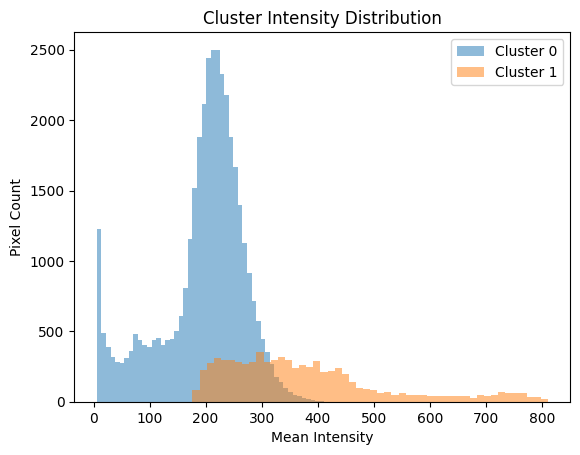

In [11]:
import matplotlib.pyplot as plt

# Visualize pixel distributions for each cluster
for i in range(n_clusters):
    
    plt.hist(hsi_reshaped[labels == i].mean(axis=1), bins=50, alpha=0.5, label=f"Cluster {i}")

plt.title("Cluster Intensity Distribution")
plt.xlabel("Mean Intensity")
plt.ylabel("Pixel Count")
plt.legend()
plt.show()

In [14]:
# Reshape the labels back to the original image dimensions
segmentation_mask = labels.reshape(height, width)

# Identify which cluster corresponds to blueberries
# Assume the cluster with higher spectral intensity corresponds to blueberries
cluster_means = [hsi_reshaped[labels == i].mean() for i in range(n_clusters)]
blueberry_cluster = np.argmax(cluster_means)  # Adjust if needed based on inspection

# Create the binary mask for blueberries
binary_mask = (segmentation_mask == blueberry_cluster)

#binary_mask = ~binary_mask  # FOR WHEN THE BLUEBERRY IS MASKED(BACKGROUND KEPT)

# Remove small artifacts and close gaps
binary_mask = remove_small_objects(binary_mask, min_size=1000)
binary_mask = binary_closing(binary_mask)

# Apply the mask to the original HSI data
masked_hsi = hsi_data * binary_mask[:, :, np.newaxis]

In [ ]:
'''
# Calculate the mean spectral intensity for each cluster
cluster_means = [hsi_reshaped[labels == i].mean(axis=0).sum() for i in range(n_clusters)]

# Dynamically identify the blueberry cluster
# If blueberries tend to have a lower mean intensity, use np.argmin instead
blueberry_cluster = np.argmin(cluster_means)  # Use np.argmin if needed

# Create the binary mask
binary_mask = (segmentation_mask == blueberry_cluster)

# Remove small artifacts and close gaps
binary_mask = remove_small_objects(binary_mask, min_size=500)
binary_mask = binary_closing(binary_mask)

# Apply the mask to the original HSI data
masked_hsi = hsi_data * binary_mask[:, :, np.newaxis]
'''

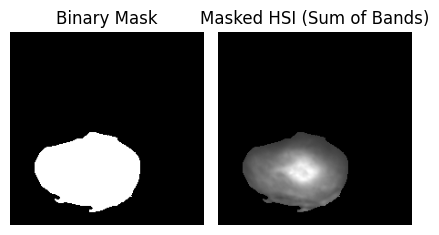

In [15]:
# Save the masked HSI data (optional)
np.save("masked_hsi.npy", masked_hsi)

plt.subplot(1, 3, 2)
plt.title("Binary Mask")
plt.imshow(binary_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Masked HSI (Sum of Bands)")
plt.imshow(masked_hsi.sum(axis=-1), cmap="grey")  # Sum across bands for visualization
plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
masked_hsi.shape

(219, 211, 462)

In [11]:
# Assuming `masked_hsi` is the masked hyperspectral image
# and has the shape (height, width, bands)
output_bil = "masked_hsi2.bil"  # Path for the BIL file
output_hdr = "masked_hsi2.hdr"  # Path for the HDR file

# Save the masked HSI as ENVI format
# Create a metadata dictionary for ENVI
height, width, bands = masked_hsi.shape

metadata = {
    'lines': height,               # Number of rows (image height)
    'samples': width,              # Number of columns (image width)
    'bands': bands,                # Number of spectral bands
    'interleave': 'bil',           # Data interleaving format
    'data type': 4,                # Float32 data type (use 4 for ENVI format)
    'byte order': 0,               # Little-endian
    'wavelength units': 'Unknown'  # Specify units if available
}

# Save the file
spectral.envi.save_image(output_hdr, masked_hsi, metadata=metadata, force=True)

print(f"Saved BIL file: {output_bil}")
print(f"Saved HDR file: {output_hdr}")

Saved BIL file: masked_hsi2.bil
Saved HDR file: masked_hsi2.hdr
